In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
import seaborn as sns

Using TensorFlow backend.


In [2]:
import Consultas_entrenar as ent

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\paula\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
consultas= pd.read_excel('datos\consultas.xls')
personas= pd.read_excel('datos\personas.xls')

WARNING *** file size (18262265) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


In [4]:
print("Cantidad de consultas: ", len(consultas))
print("Cantidad de personas: ", len(personas))

Cantidad de consultas:  47346
Cantidad de personas:  64999


In [5]:
personas.head()

,PERNROINT,PERFCHNACI,PERSEXO,PERSUBFAL,EMIPERNROI,RECEPCOD,JBSOLPERNI,110,120,121,...,48,90,91,92,93,94,95,96,97,PER_COL_PRIV
0,80,1967-08-07 00:00:00,M,,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,100000,1952-06-13 00:00:00,M,S,NaN,NaN,100000.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,150000,1960-06-09 00:00:00,F,N,NaN,NaN,150000.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,150000.0
3,160000,1964-01-25 00:00:00,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,280000,1951-12-03 00:00:00,M,S,NaN,NaN,280000.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [6]:
from datetime import datetime

ahora = datetime.utcnow()
personas['PERFCHNACI']=pd.to_datetime(personas['PERFCHNACI'], errors = 'coerce')
personas['edad']= ((ahora-personas['PERFCHNACI']).dt.days)/365

personas["resideExt"]=0
personas.loc[personas["RECEPCOD"]==8,'resideExt']=1



personas['PERSUBFAL']=personas['PERSUBFAL'].fillna('N')
personas['PERSUBFAL']=personas['PERSUBFAL'].replace(' ', 'N')


personas=personas.fillna(0)
personas.loc[personas['PER_COL_PRIV']!=0, 'PER_COL_PRIV' ] = 1


personas.drop(['JBSOLPERNI','PERFCHNACI', 'RECEPCOD', 'EMIPERNROI', 'TRAPERINT'], axis=1, inplace=True)

In [7]:
personas.head()

,PERNROINT,PERSEXO,PERSUBFAL,110,120,121,130,150,160,170,...,91,92,93,94,95,96,97,PER_COL_PRIV,edad,resideExt
0,80,M,N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53.052055,0
1,100000,M,S,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.210959,0
2,150000,F,N,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,60.216438,0
3,160000,F,N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.586301,0
4,280000,M,S,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.739726,0


In [8]:
#personas=personas.astype('int32')
dataset=pd.merge(consultas, personas, how='left', left_on='RECPERNROI', right_on='PERNROINT')
dataset=dataset.fillna(0)
print(len(dataset))


47346


In [9]:
dataset.head()

,RECLAID,RECPERNROI,RECFECHA,RECTIPID,RECTIPDESC,RECDETOBSE,PERNROINT,PERSEXO,PERSUBFAL,110,...,91,92,93,94,95,96,97,PER_COL_PRIV,edad,resideExt
0,2,258068,2012-02-13,10,Haber Impago,EL TITULAR MANIFIESTA MEDIANTE NOTA N° STICKER...,258068.0,M,S,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.471233,0.0
1,41,449461,2012-02-22,6,Mutuales,LA TITUALR RECLAMA POR DESCUENTOS REALIZADOS D...,449461.0,F,S,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.380822,0.0
2,129,12395,2012-03-08,10,Haber Impago,Se solicitará el desarchivo del expediente a ...,12395.0,M,S,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,92.657534,0.0
3,130,12965,2012-03-08,10,Haber Impago,La titular presenta baja de Consejo Deliberan...,12965.0,F,S,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84.789041,0.0
4,464,59482,2012-04-27,10,Haber Impago,Solicita la heredera se revea el cálculo de l...,59482.0,F,S,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62.641096,0.0


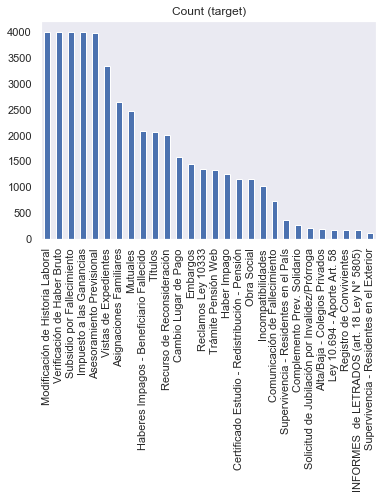

In [10]:
sns.set(style="dark")
target_count = dataset.RECTIPDESC.value_counts()
nro_tipos= dataset.RECTIPDESC.nunique()
target_count.plot(kind='bar', title='Count (target)')

In [11]:
#Reorganizar el orden de las columnas
dataset=pd.concat([dataset.iloc[:, 4:6], dataset.iloc[:, 7:]], axis=1)


In [13]:
#Guardar parte de los datos para evaluacion
X_dataset, evaluacion, y_data, y_eval =ent.split_dataset(dataset,dataset['RECTIPDESC'], 0.05 )
X_dataset=X_dataset.reset_index()
y_data=y_data.reset_index()
evaluacion.to_excel('evaluacion.xls')

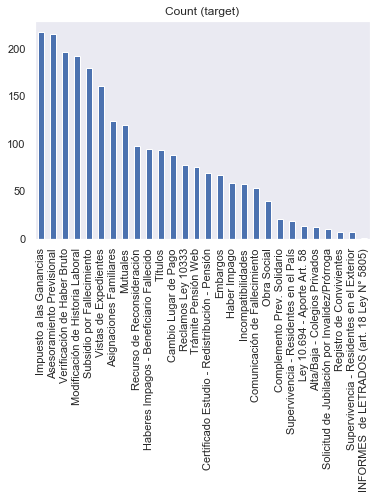

In [14]:
target_count = evaluacion.RECTIPDESC.value_counts()
target_count.plot(kind='bar', title='Count (target)')

In [15]:
print("Datos para Training y evaluacion:", len(X_dataset))

Datos para Training y evaluacion: 44978


In [16]:
corpus=ent.armar_bag_of_words(X_dataset["RECDETOBSE"])

In [17]:
obse_vec=ent.contar_palabras(corpus, 5000)
obse_vec=pd.DataFrame(obse_vec)


In [18]:
X_dataset=pd.get_dummies(X_dataset, columns=['PERSUBFAL'])
X_dataset=pd.get_dummies(X_dataset, columns=['PERSEXO'])

In [24]:
X=pd.concat([X_dataset.iloc[:, 3:], obse_vec], axis=1)


In [25]:
X.head()

,110,120,121,130,150,160,170,180,210,220,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
y= X_dataset.iloc[:, 1].values

In [27]:
X=pd.DataFrame(X)

X=X.astype('int32')

In [ ]:
X.iloc[0:5,:].to_csv('X_train2.csv')

In [28]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=4)
skf.get_n_splits(X, y)

print(skf)

StratifiedKFold(n_splits=4, random_state=None, shuffle=False)


In [29]:
def evaluar_modelo(X, y, nro_tipos, n_oculto, i_epochs, i_batch_size):
    StratifiedKFold(n_splits=4, random_state=None, shuffle=False)
    scores=[]
    mejor_acc=0
    for train_index, test_index in skf.split(X, y):
        X_train, X_test=X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test=y[train_index], y[test_index]
    
        epochs=i_epochs
        batch_size=i_batch_size
        y_train= pd.get_dummies(y_train, columns=[0])
        y_test= pd.get_dummies(y_test, columns=[0])
      
        score=[]
        for i in range(0, len(epochs)):
            tf.keras.backend.clear_session()
            for j in range(0, len(batch_size)):
                ann = None
                ann= ent.create_model(nro_tipos, n_oculto)
                ann.fit(X_train.to_numpy(), y_train, batch_size = batch_size[j], epochs = epochs[i])
                y_pred = ann.predict(X_test)
                accuracy=accuracy_score(y_test.values.argmax(axis=1), y_pred.argmax(axis=1))
                if (mejor_acc < accuracy):
                    mejor_acc=accuracy
                    mejor_par=[n_oculto, epochs[i], batch_size[j]]

                score.append(accuracy)
                print("Next")
        del X_train, X_test, y_train, y_test
        scores.append(score)
    return scores, mejor_par

In [ ]:
def evaluar_modelov2(X, y, nro_tipos, n_oculto, i_epochs, i_batch_size):
    StratifiedKFold(n_splits=4, random_state=None, shuffle=False)
    scores=[]
    mejor_acc=0
    
    epochs=i_epochs
    batch_size=i_batch_size

    score=[]

  for i in range(0, len(epochs)):
    tf.keras.backend.clear_session()
    for j in range(0, len(batch_size)):
      ann = None
      ann= ent.create_model(nro_tipos, n_oculto)

      for train_index, test_index in skf.split(X, y):
        X_train, X_test=X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test=y[train_index], y[test_index]
     
        y_train= pd.get_dummies(y_train, columns=[0])
        y_test= pd.get_dummies(y_test, columns=[0])
      
        ann.fit(X_train.to_numpy(), y_train, batch_size = batch_size[j], epochs = epochs[i])
        y_pred = ann.predict(X_test)
        accuracy=accuracy_score(y_test.values.argmax(axis=1), y_pred.argmax(axis=1))
                  
        if (mejor_acc < accuracy):
          mejor_acc=accuracy
          mejor_par=[n_oculto, epochs[i], batch_size[j]]

        score.append(accuracy)

        del X_train, X_test, y_train, y_test
        scores.append(score)
  return scores, mejor_par

In [35]:
scores, mejor_par=evaluar_modelo(X, y, nro_tipos, [60], [5], [32])

Epoch 1/5
1055/1055 [==============================] - 2s 2ms/step - loss: 0.0630 - accuracy: 0.7175
Epoch 2/5
1055/1055 [==============================] - 2s 2ms/step - loss: 0.0302 - accuracy: 0.8619
Epoch 3/5
1055/1055 [==============================] - 3s 3ms/step - loss: 0.0231 - accuracy: 0.8928
Epoch 4/5
1055/1055 [==============================] - 2s 2ms/step - loss: 0.0187 - accuracy: 0.9140
Epoch 5/5
1055/1055 [==============================] - 2s 2ms/step - loss: 0.0155 - accuracy: 0.9311
Next
Epoch 1/5
1055/1055 [==============================] - 2s 2ms/step - loss: 0.0623 - accuracy: 0.7214
Epoch 2/5
1055/1055 [==============================] - 2s 2ms/step - loss: 0.0308 - accuracy: 0.8587
Epoch 3/5
1055/1055 [==============================] - 2s 2ms/step - loss: 0.0235 - accuracy: 0.8906
Epoch 4/5
1055/1055 [==============================] - 2s 2ms/step - loss: 0.0189 - accuracy: 0.9119
Epoch 5/5
1055/1055 [==============================] - 2s 2ms/step - loss: 0.0157 - ac

In [36]:
scores2, mejor_par2=evaluar_modelo(X, y, nro_tipos, [60], [4], [32])

Epoch 1/4
1055/1055 [==============================] - 2s 2ms/step - loss: 0.0625 - accuracy: 0.7304
Epoch 2/4
1055/1055 [==============================] - 2s 2ms/step - loss: 0.0307 - accuracy: 0.8592
Epoch 3/4
1055/1055 [==============================] - 2s 2ms/step - loss: 0.0232 - accuracy: 0.8925
Epoch 4/4
1055/1055 [==============================] - 2s 2ms/step - loss: 0.0189 - accuracy: 0.9142
Next
Epoch 1/4
1055/1055 [==============================] - 2s 2ms/step - loss: 0.0637 - accuracy: 0.7148
Epoch 2/4
1055/1055 [==============================] - 2s 2ms/step - loss: 0.0306 - accuracy: 0.8609
Epoch 3/4
1055/1055 [==============================] - 2s 2ms/step - loss: 0.0230 - accuracy: 0.8928
Epoch 4/4
1055/1055 [==============================] - 2s 2ms/step - loss: 0.0187 - accuracy: 0.9137
Next
Epoch 1/4
1055/1055 [==============================] - 2s 2ms/step - loss: 0.0620 - accuracy: 0.7248
Epoch 2/4
1055/1055 [==============================] - 2s 2ms/step - loss: 0.0298

In [42]:
scores3, mejor_par3=evaluar_modelo(X, y, nro_tipos, [15, 30], [3, 4], [32, 40])
scores3=pd.DataFrame(scores3)

Epoch 1/3
1055/1055 [==============================] - 2s 1ms/step - loss: 0.0830 - accuracy: 0.5777
Epoch 2/3
1055/1055 [==============================] - 1s 1ms/step - loss: 0.0429 - accuracy: 0.8011
Epoch 3/3
1055/1055 [==============================] - 1s 1ms/step - loss: 0.0341 - accuracy: 0.8410
Next
Epoch 1/3
844/844 [==============================] - 1s 2ms/step - loss: 0.0860 - accuracy: 0.5673
Epoch 2/3
844/844 [==============================] - 1s 1ms/step - loss: 0.0422 - accuracy: 0.8021
Epoch 3/3
844/844 [==============================] - 1s 1ms/step - loss: 0.0331 - accuracy: 0.8453
Next
Epoch 1/4
1055/1055 [==============================] - 2s 2ms/step - loss: 0.0788 - accuracy: 0.6079
Epoch 2/4
1055/1055 [==============================] - 2s 2ms/step - loss: 0.0404 - accuracy: 0.8132
Epoch 3/4
1055/1055 [==============================] - 2s 1ms/step - loss: 0.0319 - accuracy: 0.8519
Epoch 4/4
1055/1055 [==============================] - 2s 1ms/step - loss: 0.0270 - acc

In [43]:
scores=pd.DataFrame(scores)
scores2=pd.DataFrame(scores2)
scores3=pd.DataFrame(scores3)

In [46]:
scores3

,0,1,2,3
0,0.809960,0.814584,0.814051,0.811827
1,0.815296,0.804802,0.810049,0.810938
2,0.812255,0.810477,0.808698,0.814123
3,0.806564,0.825329,0.809943,0.819192


In [47]:
resultado=pd.concat([scores, scores2, scores3], axis=1)
resultado.columns=[0,1,2,3,4,5]
resultado

,0,1,2,3,4,5
0,0.841885,0.847399,0.809960,0.814584,0.814051,0.811827
1,0.844998,0.842952,0.815296,0.804802,0.810049,0.810938
2,0.840359,0.839381,0.812255,0.810477,0.808698,0.814123
3,0.839826,0.841693,0.806564,0.825329,0.809943,0.819192


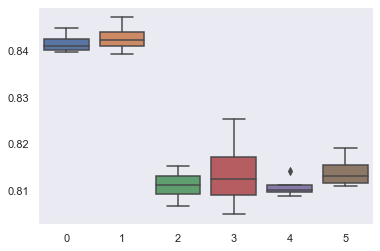

In [48]:
sns.boxplot(data=resultado)


In [40]:
def entrenar_mejor(X, y, nro_tipos, n_oculto, i_epochs, i_batch_size):
  y= pd.get_dummies(y, columns=[0])
  tf.keras.backend.clear_session()
  ann = None
  ann= ent.create_model(nro_tipos, n_oculto)
  ann.fit(X.to_numpy(), y, batch_size = i_batch_size, epochs = i_epochs)
  return ann

In [41]:
# Entrenar mejor modelo y guardar 
ann= entrenar_mejor(X, y, nro_tipos, mejor_par2[0], mejor_par2[1], mejor_par2[2])
ann.save('modeloCrossVal.h5')

Epoch 1/4
1406/1406 [==============================] - 3s 2ms/step - loss: 0.0564 - accuracy: 0.7483
Epoch 2/4
1406/1406 [==============================] - 3s 2ms/step - loss: 0.0289 - accuracy: 0.8659
Epoch 3/4
1406/1406 [==============================] - 3s 2ms/step - loss: 0.0223 - accuracy: 0.8954
Epoch 4/4
1406/1406 [==============================] - 3s 2ms/step - loss: 0.0184 - accuracy: 0.9148
